# DCGAN

## Introduction
Deep Convolutional GAN, also called DCGAN, was proposed by A. Radford, L. Metz and S. Chintala in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434). It is a commonly-used GAN architecture for image generation nowadays and viewd as a more stable set of architectures for GAN. DCGAN is just another architecture of GAN; there's no new math in it. We will only focus on the structure of DCGAN in the presentation. Also, **we assume the audience are familiar with CNN**.

## Key Points of DCGAN
These are architecture guidelines for stable Deep Convolutional GANs proposed by the original paper.
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

## Discriminator
The discriminator is simply a CNN.

The [link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) gives a nice visualization of convolutions.
```
CLASS torch.nn.Conv2d(in_channels, out_channels, kernel_size,
      stride=1, padding=0, dilation=1, groups=1, bias=True,
      padding_mode='zeros', device=None, dtype=None)
```
We typically use the default values of `output_padding`, `groups`, and `dilation`.

The output size after the input passing a convolutional layer:
$$
\left(\frac{H_{in}+2p-m}{s}+1\right)\times\left(\frac{W_{in}+2p-m}{s}+1\right)\times N
$$
- $H_{in},W_{in}$: height and width of the input
- $p$: padding
- $s$: stride
- $m$: kernel size
- $N$: batch size

Key points in the paper:
- Replace any pooling layers with strided convolutions (discriminator)
- Use batchnorm in the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use LeakyReLU activation in the discriminator for all layers.


In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            # nn.Dropout2d(0.25),
            nn.Conv2d(256, 1, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Sigmoid()
        )
    def forward(self,x):
        output = self.model(x)
        output = output.view(-1,1).squeeze(1)
        return output

#### A note on `torch.Tensor.view`
Probably the most confusing function in torch. The input is the tuple of the size of your tensor after reshapeing.

In [ ]:
import torch
data = torch.randn((64,1,28,28))
data.shape

torch.Size([64, 1, 28, 28])

In [ ]:
data.view((64,1,784)).shape

torch.Size([64, 1, 784])

You can use -1 in a particular dimension in which the dimensionality is inferred.

In [ ]:
data.view((64,1,-1)).shape

torch.Size([64, 1, 784])

In [ ]:
data.view(-1,1).shape

torch.Size([50176, 1])

## Generator
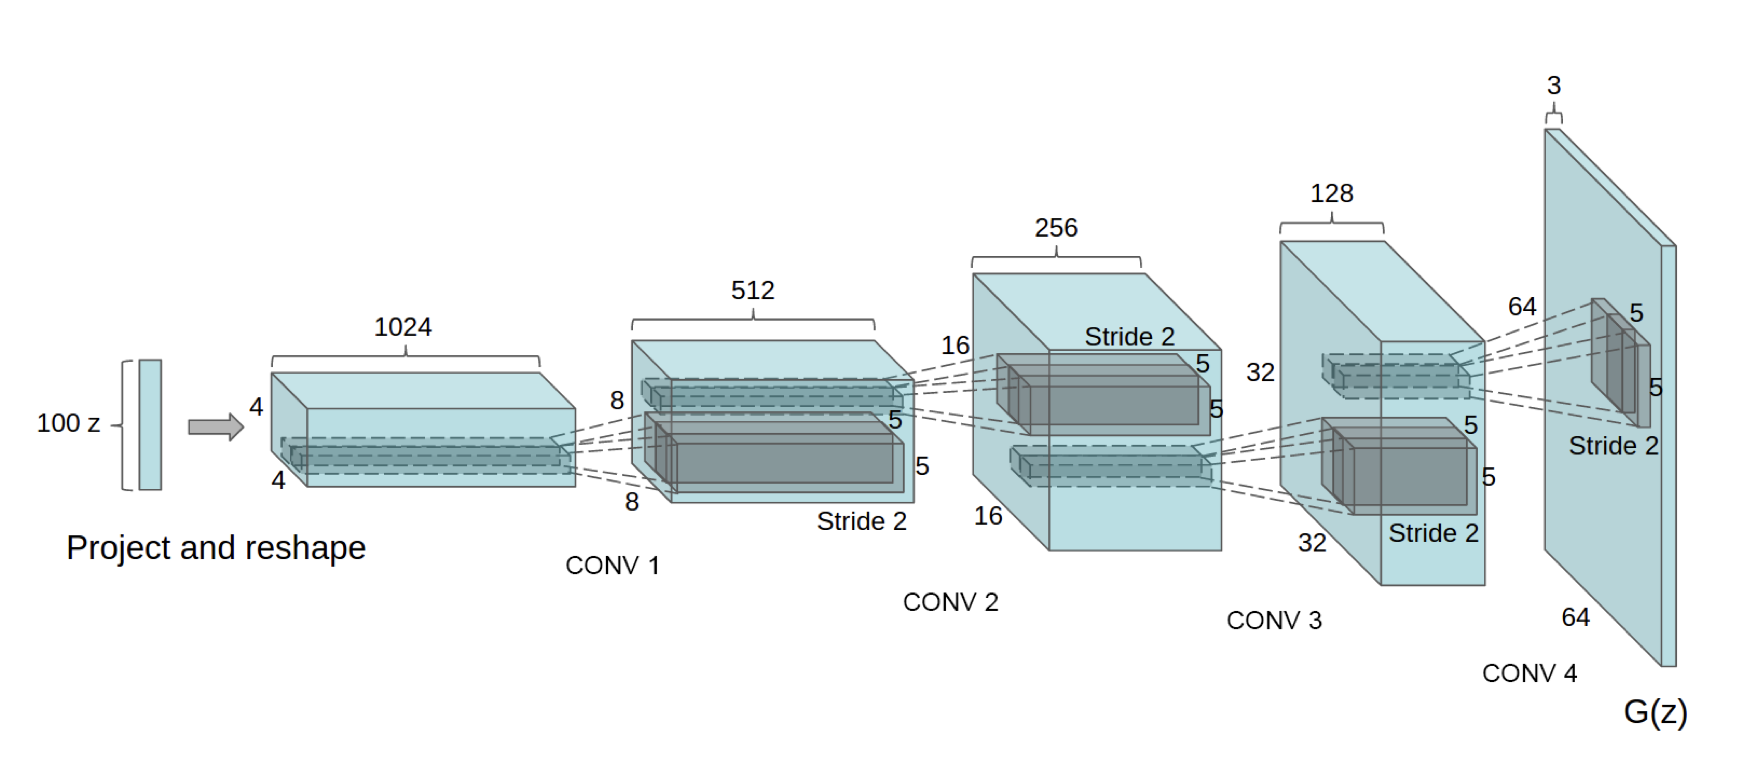

The input is a 100-dimensional noise vector sampled from a uniform (or normal) distribution, and it is projected to a small spatial extent convolutional representation with many feature maps, 1024 in this case. A series of four **fractionally-strided convolutions** (in some recent papers, these are wrongly called **deconvolutions**) then convert this high level representation into a $64 \times 64$ pixel image. **No fully connected or pooling layers** are used.

In practice, we use `nn.ConvTranspose2d` to achieve upsampling. The link [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) has a nice visualization of transposed convolutions.
```
CLASS torch.nn.ConvTranspose2d(in_channels, out_channels,
      kernel_size, stride=1, padding=0, output_padding=0, groups=1,
      bias=True, dilation=1, padding_mode='zeros', device=None,
      dtype=None)
```
Again, we typically use the default values of `output_padding`, `groups`, and `dilation`.

Input shape: $(N,C_{in},H_{in},W_{in})$

Output shape: $(N,C_{out},H_{out},W_{out})$

where $N$ denotes the batch size, $C_{in}$ / $C_{out}$ are number of input / output channels. $H$ and $W$ are height and width.

The formula of the output height and width:
$$
H_{out}=(H_{in}-1)*\text{stride}[0]-2*\text{padding}[0]+\text{dilation}[0]*(\text{kernel size}[0]-1)+\text{output padding}[0]+1
$$

$$
W_{out}=(W_{in}-1)*\text{stride}[1]-2*\text{padding}[1]+\text{dilation}[1]*(\text{kernel size}[1]-1)+\text{output padding}[1]+1
$$
Using the default values of `output_padding`, `groups`, and `dilation`, the output height and width become
$$
H_{out}=(H_{in}-1)*\text{stride}[0]-2*\text{padding}[0]+(\text{kernel size}[0]-1)+1
$$

$$
W_{out}=(W_{in}-1)*\text{stride}[1]-2*\text{padding}[1]+(\text{kernel size}[1]-1)+1
$$

Key points in the paper:
- Replace any pooling layers with fractional-strided convolutions (generator).
- Use batchnorm in the generator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 1, 1, 1, 2, bias=False),
                nn.Tanh()
            )

    def forward(self, x):
        output = self.model(x)
        return output

## PyTorch Implementation

In [ ]:
!nvidia-smi

Sun Oct  1 04:50:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import itertools
import math

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

/home/levi/miniconda3/envs/ML2023/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    'lr':0.0002,
    'n_epoch':10,
    'batch_size':16, 
}

In [3]:
def same_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seed(0)

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

In [5]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.04)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.04)  # 0.04
        m.bias.data.fill_(0)

In [6]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator,self).__init__()

        # No dropout!!
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(256, 1, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Sigmoid()
        )
    def forward(self,x):
        output = self.model(x)
        output = output.view(-1,1).squeeze(1)
        return output

In [7]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 1, 1, 1, 2, bias=False),
                nn.Tanh()
            )

    def forward(self, x):
        output = self.model(x)
        return output

In [8]:
D = Discriminator().cuda()
G = Generator().cuda()
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [9]:
Loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas = (0.5, 0.999))

In [10]:
# Draw samples from the input distribution to inspect the generation on training
fixed_number_samples = 16
fixed_noise = Variable(torch.randn(fixed_number_samples, 100,1,1)).cuda()

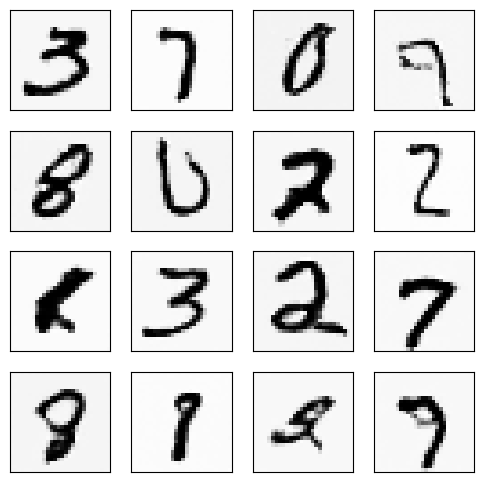

epoch: 9
d_loss: tensor(1.3945, device='cuda:0', grad_fn=<AddBackward0>) g_loss: tensor(0.8027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


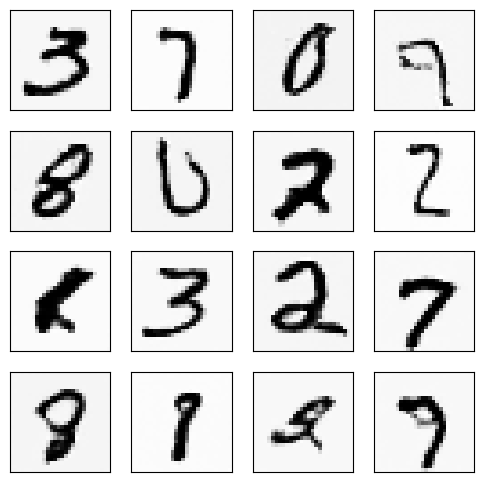

In [11]:
size_figure_grid = int(math.sqrt(fixed_number_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

for epoch in range(config['n_epoch']):
    for n, (batch_imgs, _) in enumerate(train_loader):

        # Train discriminator
        D.zero_grad()
        real_labels = torch.ones(batch_imgs.size()[0])
        real_out = D(batch_imgs.cuda())
        real_loss = Loss(real_out.cuda(),real_labels.cuda())

        fake_labels = torch.zeros(batch_imgs.size()[0])
        noise_vectors = torch.randn(batch_imgs.size()[0],100,1,1)
        fake_imgs = G(noise_vectors.cuda())
        fake_out = D(fake_imgs.cuda())
        fake_loss = Loss(fake_out.cuda(),fake_labels.cuda())

        d_loss = real_loss+fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        G.zero_grad()
        noise_vectors = torch.randn(batch_imgs.size()[0],100,1,1)
        fake_imgs = G(noise_vectors.cuda())
        fake_out = D(fake_imgs.cuda())

        g_loss = Loss(fake_out.cuda(),real_labels.cuda())
        g_loss.backward()
        g_optimizer.step()

        if (n+1) % 100 == 0:
            test_images = G(fixed_noise.cuda())
            test_images = test_images.data.cpu().numpy().reshape(test_images.size()[0],28, 28)
            for k in range(fixed_number_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k], cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print('epoch:',epoch)
            print('d_loss:',d_loss,'g_loss:',g_loss)



### Observation
DCGAN seems to have the same problem as of GAN. The loss still oscillates and you don't know when the model will converge. Sometimes the images look good, and sometimes mode collapse occurs. The performance with more than 2 epochs is much worser than the performance with 2 epochs. It seems that the model will never converge if we train it even with many epochs. If you're unlucky, your training will end at mode collapse, which prevents you from obtaining a good result. 

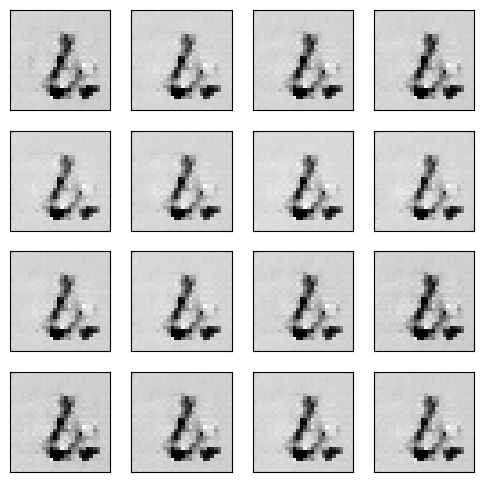

## References
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, https://arxiv.org/abs/1511.06434
- https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
- https://numbersmithy.com/understanding-transposed-convolutions-in-pytorch/#org2bcc0a0
- Multi-Scale Context Aggregation by Dilated Convolutions, https://arxiv.org/pdf/1511.07122.pdf
- https://www.kaggle.com/code/tjac718/dcgan-on-mnist-dataset-using-pytorch